In [26]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import cv2
import time
import random
import shutil
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from collections import deque

# Data preparation

## Data Augmentation

### Emotion folder scan

Counting the amount of files in each respective emotional folder

In [4]:
# Emotion folder path
emotion_folders = {
    "angry": "train_og/angry",
    "disgust": "train_og/disgust",
    "fear": "train_og/fear",
    "happy": "train_og/happy",
    "neutral": "train_og/neutral",
    "sad": "train_og/sad",
    "surprise": "train_og/surprise"
}

# Count the number of files in each folder
for emotion, path in emotion_folders.items():
    file_count = len(os.listdir(path))
    print(f"{emotion.capitalize()} folder: {file_count} files.")

Angry folder: 3995 files.
Disgust folder: 436 files.
Fear folder: 4097 files.
Happy folder: 7215 files.
Neutral folder: 4965 files.
Sad folder: 4830 files.
Surprise folder: 3171 files.


Based on the number of files in each emotion folder, data augmentation will be utilized to increase and reduce the amount of files in each folder to balance the under and over represented classes. This will improve statistical power by increasing data diversity. The goal is to balance them at around the 3000 files mark.

### Augmentation of selected emotion folders

In [5]:
# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Paths to the input and output folders
folders_to_augment = {
    "angry": "train_og/angry",
    "disgust": "train_og/disgust",
    "fear": "train_og/fear",
    "happy": "train_og/happy",
    "neutral": "train_og/neutral",
    "sad": "train_og/sad",
    "surprise": "train_og/surprise"
}

# Output paths for the augmented dataset
output_folder = "train"
os.makedirs(output_folder, exist_ok=True)

In [6]:
# Process "happy" and "disgust" folders
for emotion, folder in folders_to_augment.items():
    print(f"Processing {emotion} data...")
    images = []
    emotion_output_folder = os.path.join(output_folder, emotion)
    os.makedirs(emotion_output_folder, exist_ok=True)

    # Load images
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))  # Resize to match input dimensions
        images.append(img)

    images = np.array(images).reshape(-1, 48, 48, 1) / 255.0  # Normalize

    if emotion == "happy" or emotion == "neutral" or emotion == "sad" or emotion == "angry" or emotion == "fear" or emotion == "surprise":
        # Reduce files to 1500
        print(f"Reducing {emotion} images to 1500...")
        selected_images = random.sample(os.listdir(folder), 1500)
        for img_name in selected_images:
            src_path = os.path.join(folder, img_name)
            dest_path = os.path.join(emotion_output_folder, img_name)
            shutil.copy(src_path, dest_path)  # Copy selected images to the new folder

    elif emotion == "disgust":
        # Augment files to 1500
        print(f"Augmenting {emotion} images to 1500...")
        datagen.fit(images)  # Fit the datagen to the dataset
        current_count = len(os.listdir(folder))
        while current_count < 2000:
            for X_batch in datagen.flow(images, batch_size=1, save_to_dir=emotion_output_folder,
                                        save_prefix='aug', save_format='png'):
                current_count += 1
                if current_count >= 2000:
                    break

print("Processing complete. Augmented dataset created.")

Processing angry data...
Reducing angry images to 1500...
Processing disgust data...
Augmenting disgust images to 1500...
Processing fear data...
Reducing fear images to 1500...
Processing happy data...
Reducing happy images to 1500...
Processing neutral data...
Reducing neutral images to 1500...
Processing sad data...
Reducing sad images to 1500...
Processing surprise data...
Reducing surprise images to 1500...
Processing complete. Augmented dataset created.


Reducing the number of files for happy, neutral, sad, angry, fear, and surprise emotion folders down to 1500 to allow better processing as bigger data folders will cause longer processing time and having 1500 files in each folder is a decent amount for training.

Augmenting the files of the disgust emotion folder from 436 images to a number closer to the rest of the emotion folders will allow for better balance preventing under-represented classes of the disgust emotion or biases towards the other emotions during training.

In [7]:
# Emotion folder path
emotion_folders = {
    "angry": "train/angry",
    "disgust": "train/disgust",
    "fear": "train/fear",
    "happy": "train/happy",
    "neutral": "train/neutral",
    "sad": "train/sad",
    "surprise": "train/surprise"
}

# Count the number of files in each folder
for emotion, path in emotion_folders.items():
    file_count = len(os.listdir(path))
    print(f"{emotion.capitalize()} folder: {file_count} files.")

Angry folder: 1500 files.
Disgust folder: 1564 files.
Fear folder: 1500 files.
Happy folder: 1500 files.
Neutral folder: 1500 files.
Sad folder: 1500 files.
Surprise folder: 1500 files.


The augmented data in disgust folder have been tweaked and increased to 1564 files while the rest of the emotion folders have been reduced to 1500 files.

## Preparation of Augmented Data

### Defining paths and function

In [3]:
# Define paths
train_path = "train"
test_path = "test"
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [4]:
# Image dimensions
IMG_SIZE = 48

In [5]:
# Function to load and preprocess data
def load_data(data_path):
    data = []
    labels = []
    for idx, category in enumerate(categories):
        folder_path = os.path.join(data_path, category)
        for img_name in os.listdir(folder_path):
            try:
                # Read and preprocess image
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale conversion
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 48x48
                data.append(img)
                labels.append(idx)  # Label corresponds to the index of the category
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)

## Preparation of Training and Testing Dataset

In [6]:
# Load training data
train_data_og, train_labels_og = load_data(train_path)

# Load testing data
test_data_og, test_labels_og = load_data(test_path)

In [7]:
# Normalize pixel values to range [0, 1]
train_data_og = train_data_og / 255.0
test_data_og = test_data_og / 255.0

In [8]:
# Add a channel dimension for compatibility with CNN (1 channel for grayscale images)
train_data = np.expand_dims(train_data_og, axis=-1)
test_data = np.expand_dims(test_data_og, axis=-1)

In [9]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels_og, num_classes=len(categories))
test_labels = to_categorical(test_labels_og, num_classes=len(categories))

### Splitting training data (into Train and Validation Sets)

In [10]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

In [11]:
# Print data shapes for verification
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", test_data.shape)

Training data shape: (9507, 48, 48, 1)
Validation data shape: (1057, 48, 48, 1)
Test data shape: (7178, 48, 48, 1)


### Visualizing and Checking of Data Images

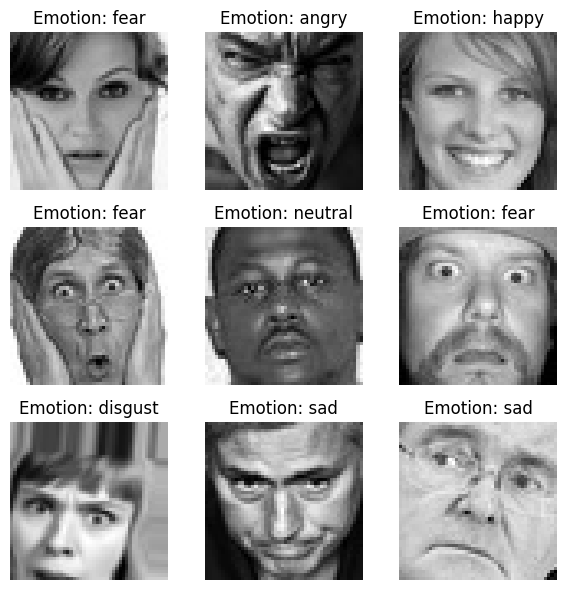

In [11]:
# Map numerical labels to emotion categories
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Number of images to display
num_images = 9  # Display 9 images for a 3x3 grid

# Create a grid of 3x3
plt.figure(figsize=(6, 6)) # Image size
rows, cols = 3, 3  # Grid size

for i in range(num_images):
    example_image = X_train[i]
    example_label = y_train[i]

    # Find the index of the emotion from the one-hot encoded label
    emotion_index = np.argmax(example_label)

    # Add a subplot for the current image
    ax = plt.subplot(rows, cols, i + 1)  # 3x3 grid, current position is i+1
    ax.imshow(example_image.squeeze(), cmap="gray")  # Squeeze to remove unnecessary dimensions
    ax.set_title(f"Emotion: {emotion_labels[emotion_index]}")
    ax.axis("off")  # Remove axes for cleaner visualization

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# 1. Base CNN Model (Version 1)

## 1.1. Scaling Up

Training CNN model with a scaled-up dataset and optimizing its architecture for better performance.

In [18]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Output layer for 3 classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
cnn_model.summary()

C:\Users\teoch\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

## 1.2. Regularisation & Tuning

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.1530 - loss: 1.9437 - val_accuracy: 0.3046 - val_loss: 1.7992
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2992 - loss: 1.7699 - val_accuracy: 0.3576 - val_loss: 1.6457
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3647 - loss: 1.6460 - val_accuracy: 0.3718 - val_loss: 1.6061
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3988 - loss: 1.5774 - val_accuracy: 0.4248 - val_loss: 1.5348
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4259 - loss: 1.4889 - val_accuracy: 0.4068 - val_loss: 1.5041
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4508 - loss: 1.4410 - val_accuracy: 0.4579 - val_loss: 1.3921
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4787 - loss: 1.3684 - val_accuracy: 0.4730 - val_loss: 1.3580
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5062 - loss: 1.3003 - val_accu

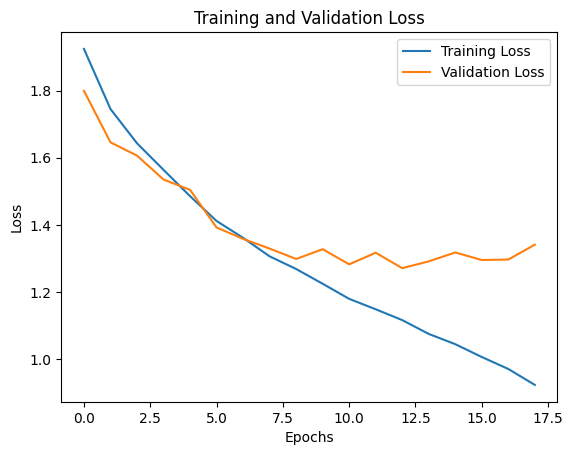

In [19]:
# Training the model with dropout regularization
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[  # Add early stopping
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Plot training and validation loss
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Get epoch with lowest validation loss
cnn_best_epoch = np.argmin(cnn_history.history['val_loss']) + 1  # Adding 1 because epochs start at 1
print(f"Best epoch: {cnn_best_epoch}")

Best epoch: 13


As seen from the graph, validation loss starts going up constantly at about 12 epochs mark while states the beginning of overfitting where the model begins recognising the data instead of generalizing to the data. The early stopping is used to prevent that while the "restored best weights" is used to roll back to the weight where validation loss is at its lowest, effectively preventing overfitting.

## 1.3. Evaluation

In [21]:
# Predict on the test data
cnn_y_pred = cnn_model.predict(test_data)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis=1)
cnn_y_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cnn_conf_matrix = confusion_matrix(cnn_y_true, cnn_y_pred_classes)
print("CNN Confusion Matrix:\n", cnn_conf_matrix)

# Classification Report
print("CNN Classification Report:\n", classification_report(cnn_y_true, cnn_y_pred_classes, target_names=categories))

# Accuracy and Sensitivity
cnn_accuracy = np.trace(cnn_conf_matrix) / np.sum(cnn_conf_matrix)
cnn_sensitivity = cnn_conf_matrix[1, 1] / np.sum(cnn_conf_matrix[1])
print(f"Accuracy: {cnn_accuracy:.2f}, Sensitivity: {cnn_sensitivity:.2f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
CNN Confusion Matrix:
 [[ 393   71   72   81  129  151   61]
 [  56   12    6    8   10   15    4]
 [ 138   75  160   76  151  240  184]
 [ 102   75   65 1176  142  140   74]
 [ 106   51   67  110  618  224   57]
 [ 190  105   98   95  251  457   51]
 [  30   13   60   45   37   42  604]]
CNN Classification Report:
               precision    recall  f1-score   support

       angry       0.39      0.41      0.40       958
     disgust       0.03      0.11      0.05       111
        fear       0.30      0.16      0.21      1024
       happy       0.74      0.66      0.70      1774
     neutral       0.46      0.50      0.48      1233
         sad       0.36      0.37      0.36      1247
    surprise       0.58      0.73      0.65       831

    accuracy                           0.48      7178
   macro avg       0.41      0.42      0.41      7178
weighted avg       0.49      0.48      0.48      7178

Accuracy: 0.48, Sensitivity: 0.11


### Confusion Matrix 

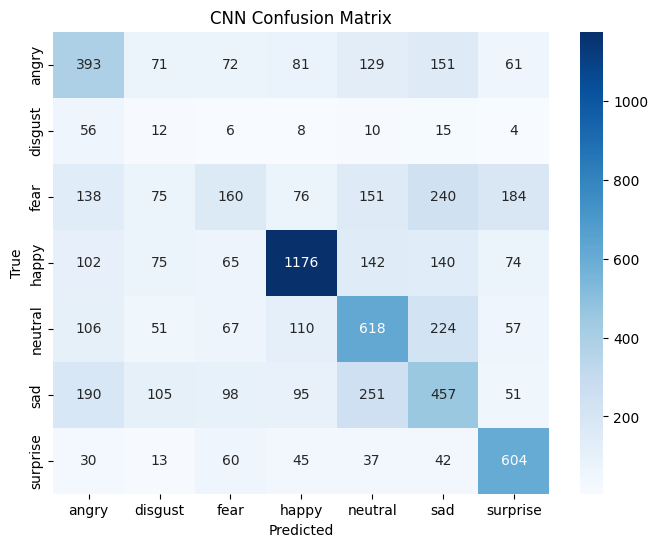

In [22]:
# Generate confusion matrix
cnn_conf_matrix = confusion_matrix(cnn_y_true, cnn_y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Sensitivity Analysis

In [23]:
# Recall (Sensitivity) per class
cnn_sensitivity_per_class = recall_score(cnn_y_true, cnn_y_pred_classes, average=None)
for i, category in enumerate(categories):
    print(f"Sensitivity for {category}: {cnn_sensitivity_per_class[i]:.4f}")

Sensitivity for angry: 0.4102
Sensitivity for disgust: 0.1081
Sensitivity for fear: 0.1562
Sensitivity for happy: 0.6629
Sensitivity for neutral: 0.5012
Sensitivity for sad: 0.3665
Sensitivity for surprise: 0.7268


### Real-Time Performance Metrics

In [24]:
# Measure time per frame for real-time prediction
def measure_real_time_performance(sample_frame):
    start_time = time.time()
    processed_frame = cv2.resize(sample_frame, (IMG_SIZE, IMG_SIZE))
    processed_frame = processed_frame / 255.0
    processed_frame = np.expand_dims(processed_frame, axis=0)
    processed_frame = np.expand_dims(processed_frame, axis=-1)
    cnn_model.predict(processed_frame)
    end_time = time.time()
    return end_time - start_time

# Example usage
sample_frame = test_data[0].reshape(IMG_SIZE, IMG_SIZE)  # Take any frame from test data
latency = measure_real_time_performance(sample_frame)
print(f"Average inference time per frame: {latency:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Average inference time per frame: 0.0753 seconds


### Saving the model for Real-Time Performance Testing 

In [25]:
# Save the model for future use
cnn_model.save("emotion_recognition_model_CNN_1.keras")

# 2. CNN Model w L2 regularization & batch normalization (Version 2)

## 2.1. Scaling Up

Training CNN model, incorporating L2 regularization together with batch normalization.

The L2 regularization will penalize any large weights as they normally lead to the overfitting of models and it will also encourage models to find patterns which are simpler and generalizable.

The Batch Normalization reduces the risk of internal covariate shift by normalizing each layer's input, stabilizing and speeding up training.

In [26]:
# Define the CNN model with regularization
cnn2_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Higher dropout for dense layer
    Dense(len(categories), activation='softmax')  # Output layer
])

# Compile the model
cnn2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
cnn2_model.summary()

C:\Users\teoch\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

## 2.2. Training

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.2428 - loss: 2.5572 - val_accuracy: 0.1391 - val_loss: 5.4084
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.3306 - loss: 2.0394 - val_accuracy: 0.1429 - val_loss: 2.7008
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.3842 - loss: 1.8735 - val_accuracy: 0.2914 - val_loss: 2.3055
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.4117 - loss: 1.7626 - val_accuracy: 0.4068 - val_loss: 1.8156
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.4733 - loss: 1.6325 - val_accuracy: 0.4607 - val_loss: 1.6940
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.4909 - loss: 1.5585 - val_accuracy: 0.3841 - val_loss: 1.8248
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.5178 - loss: 1.4708 - val_accuracy: 0.3283 - val_loss: 2.6945
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.5228 - loss: 1.4552 - 

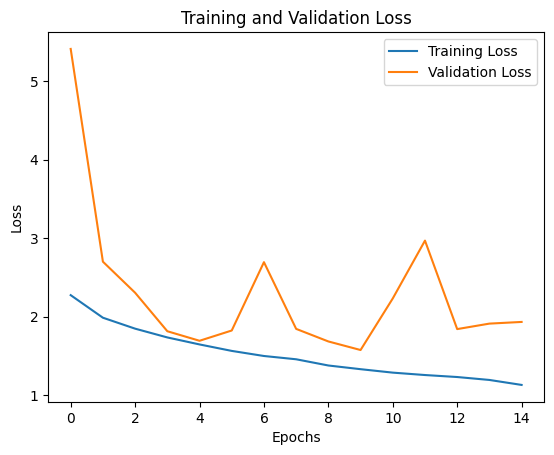

In [27]:
# Training the model with dropout regularization
cnn2_history = cnn2_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[  # Add early stopping
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Plot training and validation loss
plt.plot(cnn2_history.history['loss'], label='Training Loss')
plt.plot(cnn2_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Get epoch with lowest validation loss
cnn2_best_epoch = np.argmin(cnn2_history.history['val_loss']) + 1  # Adding 1 because epochs start at 1
print(f"Best epoch: {cnn2_best_epoch}")

Best epoch: 10


## 2.3. Evaluation

In [29]:
# Predict on the test data
cnn2_y_pred = cnn2_model.predict(test_data)
cnn2_y_pred_classes = np.argmax(cnn2_y_pred, axis=1)
cnn2_y_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cnn2_conf_matrix = confusion_matrix(cnn2_y_true, cnn2_y_pred_classes)
print("CNN 2 Confusion Matrix:\n", cnn2_conf_matrix)

# Classification Report
print("CNN 2 Classification Report:\n", classification_report(cnn2_y_true, cnn2_y_pred_classes, target_names=categories))

# Accuracy and Sensitivity
cnn2_accuracy = np.trace(cnn2_conf_matrix) / np.sum(cnn2_conf_matrix)
cnn2_sensitivity = cnn2_conf_matrix[1, 1] / np.sum(cnn2_conf_matrix[1])
print(f"Accuracy: {cnn2_accuracy:.2f}, Sensitivity: {cnn2_sensitivity:.2f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
CNN 2 Confusion Matrix:
 [[ 269   21  170   98  158  201   41]
 [  38    2   23   12   17   15    4]
 [ 101   21  292   87  173  207  143]
 [  56   21  144 1191  137  156   69]
 [  66   11  127  155  599  227   48]
 [ 111   19  217  134  308  417   41]
 [   9    5  150   47   32   33  555]]
CNN 2 Classification Report:
               precision    recall  f1-score   support

       angry       0.41      0.28      0.33       958
     disgust       0.02      0.02      0.02       111
        fear       0.26      0.29      0.27      1024
       happy       0.69      0.67      0.68      1774
     neutral       0.42      0.49      0.45      1233
         sad       0.33      0.33      0.33      1247
    surprise       0.62      0.67      0.64       831

    accuracy                           0.46      7178
   macro avg       0.39      0.39      0.39      7178
weighted avg       0.46      0.46      0.46      7178

Accuracy: 0.46, Sensitivity: 0.02


#### Confusion Matrix

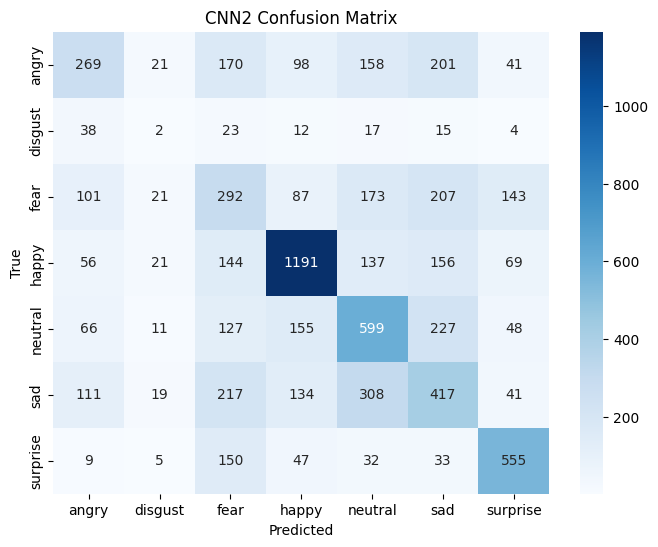

In [30]:
# Generate confusion matrix
cnn2_conf_matrix = confusion_matrix(cnn2_y_true, cnn2_y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn2_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("CNN2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Sensitivity Analysis

In [31]:
# Recall (Sensitivity) per class
cnn2_sensitivity_per_class = recall_score(cnn2_y_true, cnn2_y_pred_classes, average=None)
for i, category in enumerate(categories):
    print(f"Sensitivity for {category}: {cnn2_sensitivity_per_class[i]:.4f}")

Sensitivity for angry: 0.2808
Sensitivity for disgust: 0.0180
Sensitivity for fear: 0.2852
Sensitivity for happy: 0.6714
Sensitivity for neutral: 0.4858
Sensitivity for sad: 0.3344
Sensitivity for surprise: 0.6679


#### Real-Time Performance Metrics

In [32]:
# Measure time per frame for real-time prediction
def measure_real_time_performance(sample_frame):
    start_time = time.time()
    processed_frame = cv2.resize(sample_frame, (IMG_SIZE, IMG_SIZE))
    processed_frame = processed_frame / 255.0
    processed_frame = np.expand_dims(processed_frame, axis=0)
    processed_frame = np.expand_dims(processed_frame, axis=-1)
    cnn2_model.predict(processed_frame)
    end_time = time.time()
    return end_time - start_time

# Example usage
sample_frame = test_data[0].reshape(IMG_SIZE, IMG_SIZE)  # Take any frame from test data
latency = measure_real_time_performance(sample_frame)
print(f"Average inference time per frame: {latency:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Average inference time per frame: 0.0906 seconds


### Performance comparison

This model with the L2 regularization and batch normalization appear to be performing worse than the simpler model without them even though they are supposed to help improve generalization. Some reason might be due to over-regularization from strong L2 regularization penalty limiting the complex pattern learning ability of the model as weights are reduced to very small values. We can try a lower regularizer value next.

### Saving the model for Real-Time Performance Testing 

In [27]:
# Save the model for future use
cnn2_model.save("emotion_recognition_model_CNN_2.keras")

# 3. Model Version 1 & Version 2 Comparison

In [3]:
# Load saved models
model_1 = load_model("emotion_recognition_model_CNN_1.keras")
model_2 = load_model("emotion_recognition_model_CNN_2.keras")

In [16]:
# Evaluate all models on the same test dataset
loss_1, acc_1 = model_1.evaluate(test_data, test_labels, verbose=0)
loss_2, acc_2 = model_2.evaluate(test_data, test_labels, verbose=0)

print(f"Model 1 - Test Accuracy: {acc_1:.4f}, Test Loss: {loss_1:.4f}")
print(f"Model 2 - Test Accuracy: {acc_2:.4f}, Test Loss: {loss_2:.4f}")

Model 1 - Test Accuracy: 0.4765, Test Loss: 1.4178
Model 2 - Test Accuracy: 0.4560, Test Loss: 1.8145


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


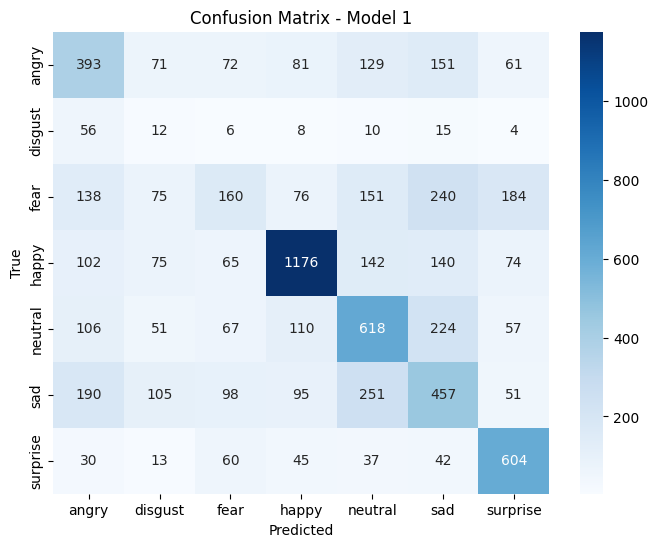

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


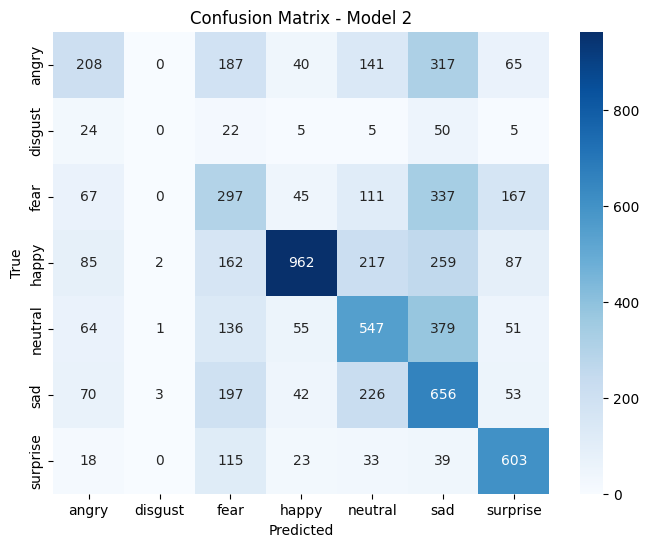

In [17]:
def plot_confusion_matrix(model, test_data, test_labels, title):
    y_pred = np.argmax(model.predict(test_data), axis=1)
    y_true = np.argmax(test_labels, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(model_1, test_data, test_labels, "Model 1")
plot_confusion_matrix(model_2, test_data, test_labels, "Model 2")

Comparison between 2 version of CNN models. The first CNN model is a basic model and the second CNN model which includes the L2 regularization and batch normalization. 

In terms of the overall accuracy, the first CNN model have a higher accuracy of 48% as compared to the second CNN model with 46%.

As for the F1-score performance, both the macro and weighted average aspect of the score favours the first CNN model too, indicating the first CNN model to have better balance across all emotion class in precision and recall.

Sensitivity wise, the first CNN model still have a higher score of 11% as compared to the second CNN model of 2%, indicating the econd model's struggle with detecting correct instances.

Class-wise performance, the second CNN model has an improved precision in classes such as "angry" and "surprise", while the recall for most of the emotion classes dropped except for "fear" and "happy" which lead to the an overall decrease in the model's effectiveness.

The reason why the first CNN model's accuracy, F1-score, and recall perform better overall as compared to the second CNN model even though the second model's L2 regularization and batch normalization is supposed to reduce overfitting might be due to over-regularizing of the model, which in turn lead to a lower overall accuracy and poorer recall in the classification of facial emotion.

# 4. CNN Model w more adjustments (Version 3)

Changing the L2 regularization value from model v2 of 0.001 to a lower value of 0.0005 to allow the training data to be fitted to the model more freely.

Lower the dropout value to allow the model to learn the dataset pattern better.

Adding a learning rate scheduler to further help avoid overfitting and optimize training time. The learning rate scheduler reduces the model's learning rate by a particular factor if the validation loss stops improving as time goes on. This will allow the model to fine-tune its weights gently rather than overshooting or stagnating during training, allowing the model to continue training.

## Creating the Model

In [22]:
# Define the CNN model with regularization
cnn_model_v3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),  # Lowered dropout value
    Dense(len(categories), activation='softmax')  # Output layer
])

# Compile the model
cnn_model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
cnn_model_v3.summary()

C:\Users\Chuang Ming Teo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

## Training the Model with learning rate scheduler

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.2520 - loss: 2.3446 - val_accuracy: 0.1750 - val_loss: 3.6510 - learning_rate: 0.0010
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.3631 - loss: 1.7910 - val_accuracy: 0.1911 - val_loss: 3.0715 - learning_rate: 0.0010
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.4196 - loss: 1.6765 - val_accuracy: 0.2791 - val_loss: 2.0902 - learning_rate: 0.0010
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.4560 - loss: 1.5630 - val_accuracy: 0.2923 - val_loss: 2.3945 - learning_rate: 0.0010
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.5021 - loss: 1.4482 - val_accuracy: 0.3974 - val_loss: 2.0826 - learning_rate: 0.0010
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5334 - loss: 1.3798 - val_accuracy: 0.4352 - val_loss: 1.6036 - learning_rate: 0.0010
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.5583 - 

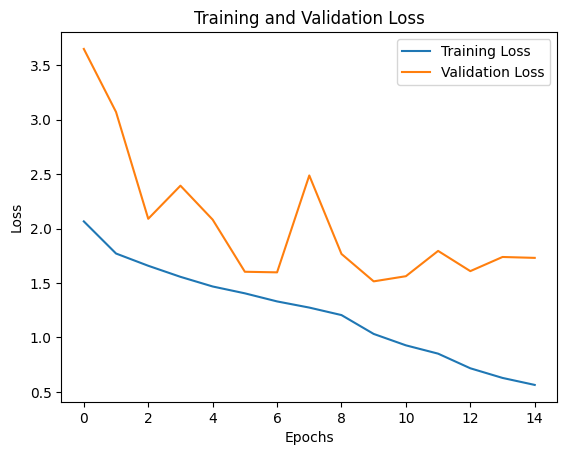

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Training the model with dropout regularization
cnn_model_v3_history = cnn_model_v3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)

# Plot training and validation loss
plt.plot(cnn_model_v3_history.history['loss'], label='Training Loss')
plt.plot(cnn_model_v3_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Get epoch with lowest validation loss
cnn3_best_epoch = np.argmin(cnn_model_v3_history.history['val_loss']) + 1  # Adding 1 because epochs start at 1
print(f"Best epoch: {cnn3_best_epoch}")

Best epoch: 10


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
CNN Model V3 Classification Report:
               precision    recall  f1-score   support

       angry       0.38      0.44      0.41       958
     disgust       0.02      0.05      0.03       111
        fear       0.28      0.32      0.30      1024
       happy       0.74      0.68      0.71      1774
     neutral       0.49      0.38      0.43      1233
         sad       0.36      0.39      0.38      1247
    surprise       0.70      0.65      0.67       831

    accuracy                           0.48      7178
   macro avg       0.43      0.41      0.42      7178
weighted avg       0.50      0.48      0.49      7178

Accuracy: 0.48, Sensitivity: 0.05


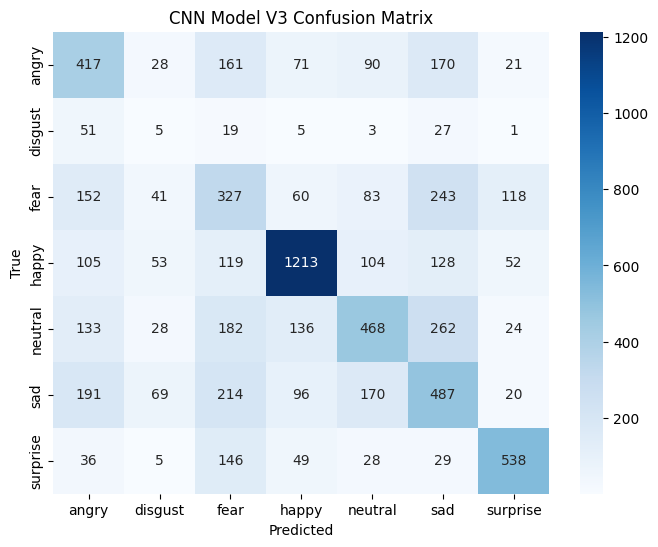

In [25]:
# Predict on the test data
cnn_v3_y_pred = cnn_model_v3.predict(test_data)
cnn_v3_y_pred_classes = np.argmax(cnn_v3_y_pred, axis=1)
cnn_v3_y_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cnn_v3_conf_matrix = confusion_matrix(cnn_v3_y_true, cnn_v3_y_pred_classes)

# Classification Report
print("CNN Model V3 Classification Report:\n", classification_report(cnn_v3_y_true, cnn_v3_y_pred_classes, target_names=categories))

# Accuracy and Sensitivity
cnn_v3_accuracy = np.trace(cnn_v3_conf_matrix) / np.sum(cnn_v3_conf_matrix)
cnn_v3_sensitivity = cnn_v3_conf_matrix[1, 1] / np.sum(cnn_v3_conf_matrix[1])
print(f"Accuracy: {cnn_v3_accuracy:.2f}, Sensitivity: {cnn_v3_sensitivity:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_v3_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("CNN Model V3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Sensitivity Analysis

In [26]:
# Recall (Sensitivity) per class
cnn_v3_sensitivity_per_class = recall_score(cnn_v3_y_true, cnn_v3_y_pred_classes, average=None)
for i, category in enumerate(categories):
    print(f"Sensitivity for {category}: {cnn_v3_sensitivity_per_class[i]:.4f}")

Sensitivity for angry: 0.4353
Sensitivity for disgust: 0.0450
Sensitivity for fear: 0.3193
Sensitivity for happy: 0.6838
Sensitivity for neutral: 0.3796
Sensitivity for sad: 0.3905
Sensitivity for surprise: 0.6474


### Real-Time Performance Metrics

In [27]:
# Measure time per frame for real-time prediction
def measure_real_time_performance(sample_frame):
    start_time = time.time()
    processed_frame = cv2.resize(sample_frame, (IMG_SIZE, IMG_SIZE))
    processed_frame = processed_frame / 255.0
    processed_frame = np.expand_dims(processed_frame, axis=0)
    processed_frame = np.expand_dims(processed_frame, axis=-1)
    cnn_model_v3.predict(processed_frame)
    end_time = time.time()
    return end_time - start_time

# Example usage
sample_frame = test_data[0].reshape(IMG_SIZE, IMG_SIZE)  # Take any frame from test data
latency = measure_real_time_performance(sample_frame)
print(f"Average inference time per frame: {latency:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Average inference time per frame: 0.0801 seconds


### Saving the model for Real-Time Performance Testing

In [28]:
# Save the model for future use
cnn_model_v3.save("emotion_recognition_model_CNN_3.keras")

# 5. Comparing the Version 1 & 3 models

In [32]:
# Load saved models
model_1 = load_model("emotion_recognition_model_CNN_1.keras")
model_3 = load_model("emotion_recognition_model_CNN_3.keras")

In [33]:
# Evaluate all models on the same test dataset
loss_1, acc_1 = model_1.evaluate(test_data, test_labels, verbose=0)
loss_3, acc_3 = model_3.evaluate(test_data, test_labels, verbose=0)

print(f"Model 1 - Test Accuracy: {acc_1:.4f}, Test Loss: {loss_1:.4f}")
print(f"Model 3 - Test Accuracy: {acc_3:.4f}, Test Loss: {loss_3:.4f}")

Model 1 - Test Accuracy: 0.4765, Test Loss: 1.4178
Model 3 - Test Accuracy: 0.4813, Test Loss: 1.6379


Comparing the first and the third models, the second model was not used in the comparison as the base model was performing better than it and the third model was fine-tuned off the second model.

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


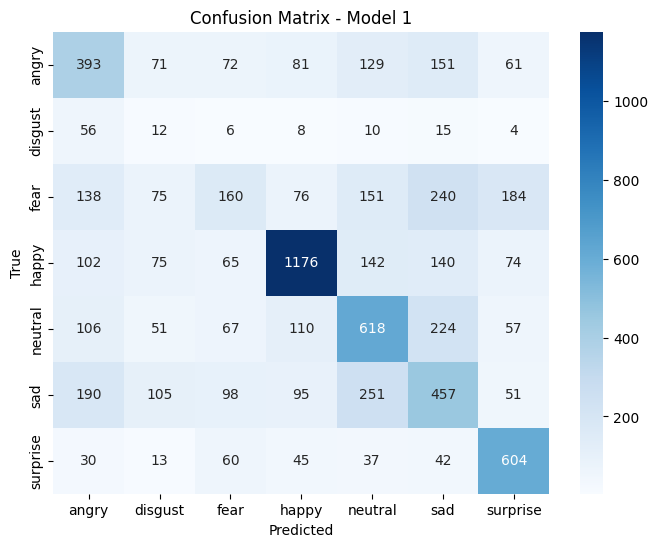

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


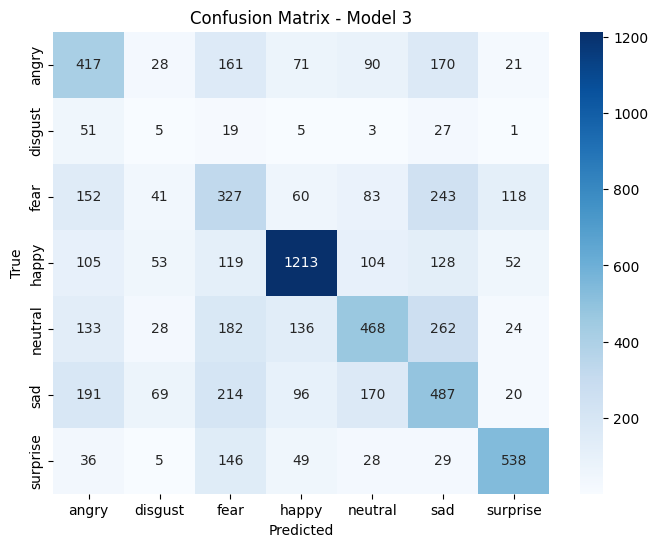

In [34]:
def plot_confusion_matrix(model, test_data, test_labels, title):
    y_pred = np.argmax(model.predict(test_data), axis=1)
    y_true = np.argmax(test_labels, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(model_1, test_data, test_labels, "Model 1")
plot_confusion_matrix(model_3, test_data, test_labels, "Model 3")

---

# 6. CNN Model Version 3 with MobileNetV2 (Version 4)

Utilizing a hybrid model like CNNs together with MobileNetV2, as it will have the benefit of custom CNN layers combined with a pre-trained model feature extraction ability of MobileNetV2.

### Making changes to training and testing dataset

Firstly, MobileNetV2 requires the 3 channels, RGB, as it is designed for RGB images. In my original dataset, the images are in grayscale so I will need to convert the grayscale from the dataset into 3-channel RGB data.

In [22]:
def preprocess_image(img):
    # Convert to 8-bit unsigned integers if it's float64 or float32
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)  # Scale back to 0-255 if normalized

    # Ensure it's 2D grayscale before converting
    if len(img.shape) == 2 or img.shape[-1] == 1:
        img = cv2.cvtColor(img.squeeze(), cv2.COLOR_GRAY2RGB)

    return img

train_data_rgb = np.array([preprocess_image(img) for img in train_data_og])
test_data_rgb = np.array([preprocess_image(img) for img in test_data_og])

Secondly, the performance of MobileNetV2 is at its best from 96×96 or larger input resolution but my input learning dataset is at 48x48, so resizing is needed.

In [23]:
# Normalize pixel values to range [0, 1]
train_data_rgb = train_data_rgb / 255.0
test_data_rgb = test_data_rgb / 255.0

In [24]:
train_data_resized = tf.image.resize(train_data_rgb, (96, 96))
train_data_resized = train_data_resized.numpy()

test_data_resized = tf.image.resize(test_data_rgb, (96, 96))

In [25]:
# Convert labels to one-hot encoding
train_labels_cat = to_categorical(train_labels_og, num_classes=len(categories))
test_labels_cat = to_categorical(test_labels_og, num_classes=len(categories))

In [26]:
# Split training data into train and validation sets
X_rgb_train, X_rgb_val, y_rgb_train, y_rgb_val = train_test_split(train_data_resized, train_labels_cat, test_size=0.1, random_state=42)

### Define CNN Model

In [17]:
# Define the CNN model with regularization
cnn_model_v4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),  # Lowered dropout value
    Dense(len(categories), activation='softmax')  # Output layer
])

# Define CNN input
cnn_input = Input(shape=(96, 96, 3))
cnn_output = cnn_model_v4(cnn_input)

C:\Users\Chuang Ming Teo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Define MobileNetV2 

In [18]:
# Define MobileNetV2 Feature Extractor
model_MN = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
model_MN.trainable = False  # Freeze model for feature extraction
mobilenet_output = GlobalAveragePooling2D()(model_MN.output)

# Define input for MobileNetV2
mobilenet_input = model_MN.input

### Combine CNN with MobileNetV2

In [19]:
# Merge CNN and MobileNetV2 Features
merged = concatenate([cnn_output, mobilenet_output])
final_output = Dense(len(categories), activation="softmax")(merged)

In [20]:
# Define the Combined Model
cnnMobileNet_model = Model(inputs=[cnn_input, mobilenet_input], outputs=final_output)

# Compile Model
cnnMobileNet_model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy")])

### Training

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 104s 665ms/step - categorical_accuracy: 0.3029 - loss: 1.9754 - val_categorical_accuracy: 0.4409 - val_loss: 1.5348 - learning_rate: 0.0010
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 94s 631ms/step - categorical_accuracy: 0.4636 - loss: 1.4445 - val_categorical_accuracy: 0.4551 - val_loss: 1.4572 - learning_rate: 0.0010
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 94s 633ms/step - categorical_accuracy: 0.5132 - loss: 1.3099 - val_categorical_accuracy: 0.4588 - val_loss: 1.4328 - learning_rate: 0.0010
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 95s 634ms/step - categorical_accuracy: 0.5386 - loss: 1.2400 - val_categorical_accuracy: 0.4693 - val_loss: 1.4220 - learning_rate: 0.0010
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 96s 645ms/step - categorical_accuracy: 0.5489 - loss: 1.2195 - val_categorical_accuracy: 0.4664 - val_loss: 1.4163 - learning_rate: 0.0010
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 94s 631ms/step - categorical_accuracy: 0.5650 - loss: 1.1792 - v

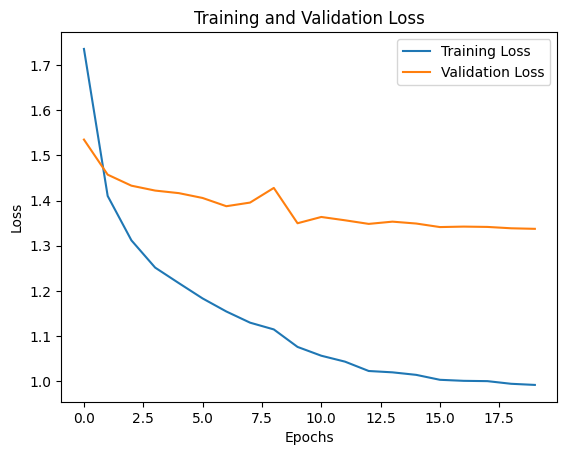

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train Model with Early Stopping
cnnMobileNet_model_history = cnnMobileNet_model.fit(
    [X_rgb_train, X_rgb_train], y_rgb_train,  # Pass both inputs
    validation_data=([X_rgb_val, X_rgb_val], y_rgb_val),  # Same for validation
    epochs=20, 
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)

# Plot training and validation loss
plt.plot(cnnMobileNet_model_history.history['loss'], label='Training Loss')
plt.plot(cnnMobileNet_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As seen from the above training validation loss, with training loss continuously decreasing but validation loss being more stagnant after the initial decrease, there is a huge gap between training loss and validation loss signifying a clear sign of overfitting.

Some ways to improve 

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step
CNN Model V4 Classification Report:
               precision    recall  f1-score   support

       angry       0.33      0.38      0.35       958
     disgust       0.02      0.04      0.03       111
        fear       0.32      0.24      0.28      1024
       happy       0.65      0.59      0.62      1774
     neutral       0.40      0.45      0.43      1233
         sad       0.37      0.31      0.34      1247
    surprise       0.53      0.69      0.60       831

    accuracy                           0.44      7178
   macro avg       0.38      0.39      0.38      7178
weighted avg       0.45      0.44      0.44      7178

Accuracy: 0.44, Sensitivity: 0.04


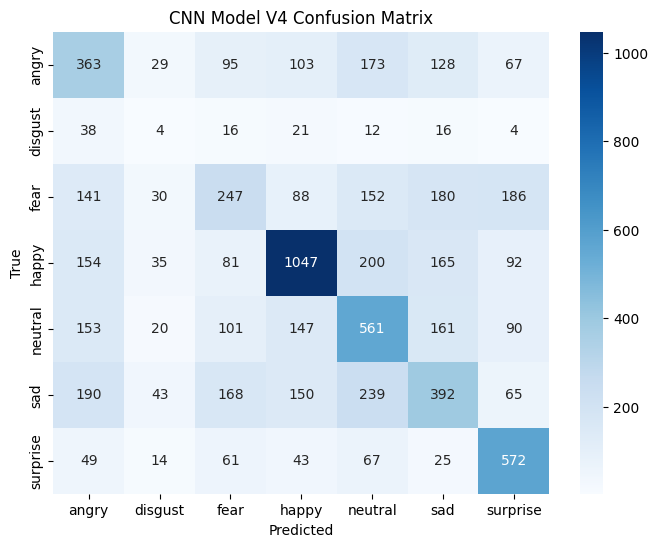

In [25]:
# Predict on the test data
cnn_v4_y_pred = cnnMobileNet_model.predict([test_data_resized, test_data_resized])
cnn_v4_y_pred_classes = np.argmax(cnn_v4_y_pred, axis=1)
cnn_v4_y_true = np.argmax(test_labels_cat, axis=1)

# Confusion Matrix
cnn_v4_conf_matrix = confusion_matrix(cnn_v4_y_true, cnn_v4_y_pred_classes)

# Classification Report
print("CNN Model V4 Classification Report:\n", classification_report(cnn_v4_y_true, cnn_v4_y_pred_classes, target_names=categories))

# Accuracy and Sensitivity
cnn_v4_accuracy = np.trace(cnn_v4_conf_matrix) / np.sum(cnn_v4_conf_matrix)
cnn_v4_sensitivity = cnn_v4_conf_matrix[1, 1] / np.sum(cnn_v4_conf_matrix[1])
print(f"Accuracy: {cnn_v4_accuracy:.2f}, Sensitivity: {cnn_v4_sensitivity:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_v4_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("CNN Model V4 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Saving the model for Real-Time Performance Testing

In [22]:
# Save the model for future use
cnnMobileNet_model.save("emotion_recognition_model_CNN_4.keras")

# 7. CNN Model Version 4 adjusted (Version 5)

Increasing dropout value from 0.4 to 0.5

Increase L2 from 0.0005 to 0.001

### Define CNN Model

In [32]:
# Define the CNN model with regularization
cnn_model_v5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Lowered dropout value
    Dense(len(categories), activation='softmax')  # Output layer
])

# Define CNN input
cnn_input_V2 = Input(shape=(96, 96, 3))
cnn_output_V2 = cnn_model_v5(cnn_input_V2)

### Define MobileNetV2 

In [29]:
# Define MobileNetV2 Feature Extractor
model_MN_V2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
model_MN_V2.trainable = False  # Freeze model for feature extraction
mobilenet_V2_output = GlobalAveragePooling2D()(model_MN_V2.output)

# Define input for MobileNetV2
mobilenet_V2_input = model_MN_V2.input

### Combine CNN with MobileNetV2

In [33]:
# Merge CNN and MobileNetV2 Features
merged_V2 = concatenate([cnn_output_V2, mobilenet_V2_output])
final_output_V2 = Dense(len(categories), activation="softmax")(merged_V2)

# Define the Combined Model
cnnMobileNet_V2_model = Model(inputs=[cnn_input_V2, mobilenet_V2_input], outputs=final_output_V2)

# Compile Model
cnnMobileNet_V2_model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy")])

### Training

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 99s 631ms/step - categorical_accuracy: 0.3052 - loss: 2.0478 - val_categorical_accuracy: 0.4182 - val_loss: 1.5334 - learning_rate: 0.0010
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 93s 624ms/step - categorical_accuracy: 0.4652 - loss: 1.4296 - val_categorical_accuracy: 0.4607 - val_loss: 1.4550 - learning_rate: 0.0010
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 93s 626ms/step - categorical_accuracy: 0.5149 - loss: 1.3064 - val_categorical_accuracy: 0.4683 - val_loss: 1.4233 - learning_rate: 0.0010
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 94s 627ms/step - categorical_accuracy: 0.5344 - loss: 1.2522 - val_categorical_accuracy: 0.4579 - val_loss: 1.4301 - learning_rate: 0.0010
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 93s 625ms/step - categorical_accuracy: 0.5513 - loss: 1.2211 - val_categorical_accuracy: 0.4721 - val_loss: 1.3966 - learning_rate: 0.0010
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 93s 624ms/step - categorical_accuracy: 0.5625 - loss: 1.1740 - va

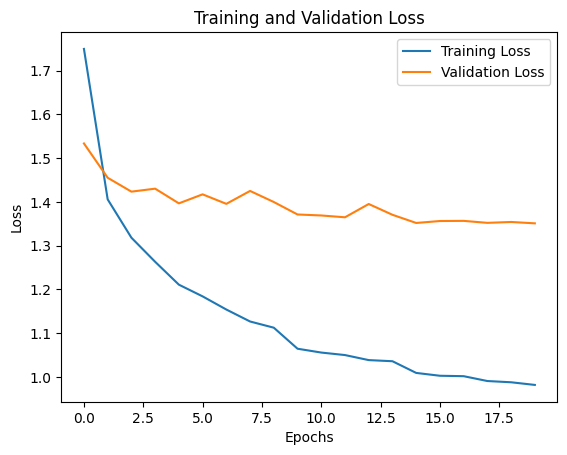

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train Model with Early Stopping
cnnMobileNet_V2_model_history = cnnMobileNet_V2_model.fit(
    [X_rgb_train, X_rgb_train], y_rgb_train,  # Pass both inputs
    validation_data=([X_rgb_val, X_rgb_val], y_rgb_val),  # Same for validation
    epochs=20, 
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)

# Plot training and validation loss
plt.plot(cnnMobileNet_V2_model_history.history['loss'], label='Training Loss')
plt.plot(cnnMobileNet_V2_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step
CNN Model V5 Classification Report:
               precision    recall  f1-score   support

       angry       0.36      0.34      0.35       958
     disgust       0.02      0.04      0.03       111
        fear       0.30      0.29      0.29      1024
       happy       0.64      0.61      0.63      1774
     neutral       0.41      0.44      0.43      1233
         sad       0.35      0.30      0.32      1247
    surprise       0.55      0.66      0.60       831

    accuracy                           0.44      7178
   macro avg       0.38      0.38      0.38      7178
weighted avg       0.44      0.44      0.44      7178

Accuracy: 0.44, Sensitivity: 0.04


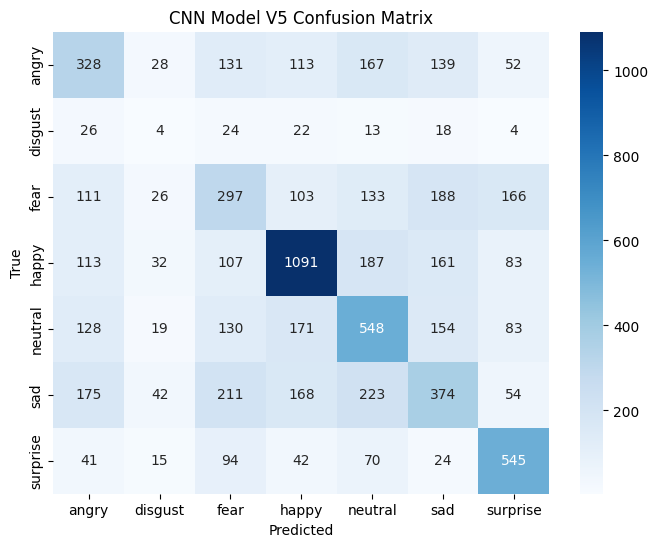

In [35]:
# Predict on the test data
cnn_v5_y_pred = cnnMobileNet_V2_model.predict([test_data_resized, test_data_resized])
cnn_v5_y_pred_classes = np.argmax(cnn_v5_y_pred, axis=1)
cnn_v5_y_true = np.argmax(test_labels_cat, axis=1)

# Confusion Matrix
cnn_v5_conf_matrix = confusion_matrix(cnn_v5_y_true, cnn_v5_y_pred_classes)

# Classification Report
print("CNN Model V5 Classification Report:\n", classification_report(cnn_v5_y_true, cnn_v5_y_pred_classes, target_names=categories))

# Accuracy and Sensitivity
cnn_v5_accuracy = np.trace(cnn_v5_conf_matrix) / np.sum(cnn_v5_conf_matrix)
cnn_v5_sensitivity = cnn_v5_conf_matrix[1, 1] / np.sum(cnn_v5_conf_matrix[1])
print(f"Accuracy: {cnn_v5_accuracy:.2f}, Sensitivity: {cnn_v5_sensitivity:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_v5_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("CNN Model V5 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 8. CNN Model Version 5 adjusted (Version 6)

An even higher L2 value of 0.004 and dropout value of 0.6 to further reduce overfitting.

Adding one more layer to the model

In [52]:
# Define the CNN model with regularization
cnn_model_v6 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.004)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.004)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.004)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.004)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.004)),
    Dropout(0.6),  # Lowered dropout value
    Dense(len(categories), activation='softmax')  # Output layer
])

# Define CNN input
cnn_input_V3 = Input(shape=(96, 96, 3))
cnn_output_V3 = cnn_model_v6(cnn_input_V3)

### Define MobileNetV2

In [53]:
# Define MobileNetV2 Feature Extractor
model_MN_V3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
model_MN_V3.trainable = False  # Freeze model for feature extraction
mobilenet_V3_output = GlobalAveragePooling2D()(model_MN_V3.output)

# Define input for MobileNetV2
mobilenet_V3_input = model_MN_V3.input

### Combine CNN with MobileNetV2

In [54]:
# Merge CNN and MobileNetV2 Features
merged_V3 = concatenate([cnn_output_V3, mobilenet_V3_output])
final_output_V3 = Dense(len(categories), activation="softmax")(merged_V3)

# Define the Combined Model
cnnMobileNet_V3_model = Model(inputs=[cnn_input_V3, mobilenet_V3_input], outputs=final_output_V3)

# Compile Model
cnnMobileNet_V3_model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy")])

### Training

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 111s 708ms/step - categorical_accuracy: 0.3013 - loss: 2.8637 - val_categorical_accuracy: 0.4503 - val_loss: 1.5224 - learning_rate: 0.0010
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 98s 654ms/step - categorical_accuracy: 0.4660 - loss: 1.4198 - val_categorical_accuracy: 0.4683 - val_loss: 1.4258 - learning_rate: 0.0010
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 96s 643ms/step - categorical_accuracy: 0.5083 - loss: 1.3045 - val_categorical_accuracy: 0.4579 - val_loss: 1.4371 - learning_rate: 0.0010
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 95s 640ms/step - categorical_accuracy: 0.5354 - loss: 1.2620 - val_categorical_accuracy: 0.4721 - val_loss: 1.3928 - learning_rate: 0.0010
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 97s 653ms/step - categorical_accuracy: 0.5511 - loss: 1.2204 - val_categorical_accuracy: 0.4721 - val_loss: 1.4035 - learning_rate: 0.0010
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 95s 639ms/step - categorical_accuracy: 0.5650 - loss: 1.1793 - v

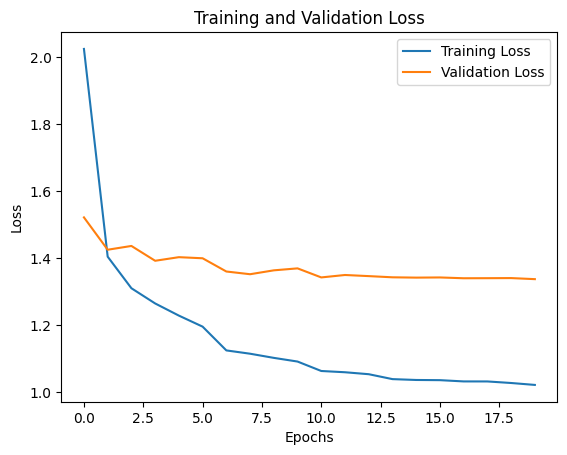

In [55]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train Model with Early Stopping
cnnMobileNet_V3_model_history = cnnMobileNet_V3_model.fit(
    [X_rgb_train, X_rgb_train], y_rgb_train,  # Pass both inputs
    validation_data=([X_rgb_val, X_rgb_val], y_rgb_val),  # Same for validation
    epochs=20, 
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)

# Plot training and validation loss
plt.plot(cnnMobileNet_V3_model_history.history['loss'], label='Training Loss')
plt.plot(cnnMobileNet_V3_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step
CNN Model V6 Classification Report:
               precision    recall  f1-score   support

       angry       0.35      0.36      0.35       958
     disgust       0.02      0.04      0.03       111
        fear       0.30      0.28      0.29      1024
       happy       0.63      0.62      0.63      1774
     neutral       0.40      0.43      0.42      1233
         sad       0.37      0.28      0.32      1247
    surprise       0.52      0.67      0.59       831

    accuracy                           0.44      7178
   macro avg       0.37      0.38      0.37      7178
weighted avg       0.44      0.44      0.44      7178

Accuracy: 0.44, Sensitivity: 0.04


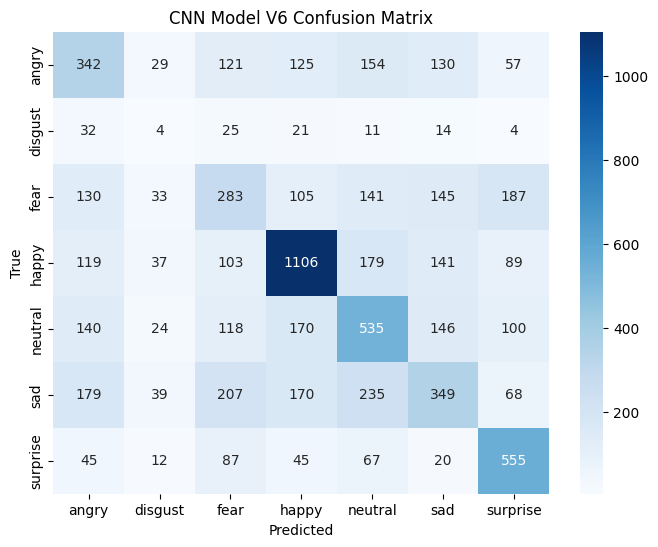

In [56]:
# Predict on the test data
cnn_v6_y_pred = cnnMobileNet_V3_model.predict([test_data_resized, test_data_resized])
cnn_v6_y_pred_classes = np.argmax(cnn_v6_y_pred, axis=1)
cnn_v6_y_true = np.argmax(test_labels_cat, axis=1)

# Confusion Matrix
cnn_v6_conf_matrix = confusion_matrix(cnn_v6_y_true, cnn_v6_y_pred_classes)

# Classification Report
print("CNN Model V6 Classification Report:\n", classification_report(cnn_v6_y_true, cnn_v6_y_pred_classes, target_names=categories))

# Accuracy and Sensitivity
cnn_v6_accuracy = np.trace(cnn_v6_conf_matrix) / np.sum(cnn_v6_conf_matrix)
cnn_v6_sensitivity = cnn_v6_conf_matrix[1, 1] / np.sum(cnn_v6_conf_matrix[1])
print(f"Accuracy: {cnn_v6_accuracy:.2f}, Sensitivity: {cnn_v6_sensitivity:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_v6_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("CNN Model V6 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

With the adjustment made to the CNN & MobileNetV2 model, the result is still not performing better than the CNN model version 3 that was improved with L2 regularization and dropout adjustment, and a learning rate scheduler. Thus I will be reverting to just the CNN model and making some slight adjustment to further improve my results.

# 9. CNN Model Version 3 adjusted (Version 7)

Let's increase the dropout value from model 3, as I might have made a mistake by doing the opposite, causing the results to deteriorate. Increasing dropout value for stronger regularization helps with the overfitting issue.

### Creating the Model

In [61]:
# Define the CNN model with regularization
cnn_model_v7 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.6),  
    Dense(len(categories), activation='softmax')  # Output layer
])

# Compile the model
cnn_model_v7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
cnn_model_v7.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

### Training the Model

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.2081 - loss: 2.4290 - val_accuracy: 0.1457 - val_loss: 3.5241 - learning_rate: 0.0010
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.2924 - loss: 1.9610 - val_accuracy: 0.1476 - val_loss: 2.8365 - learning_rate: 0.0010
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.3465 - loss: 1.8217 - val_accuracy: 0.2621 - val_loss: 2.2851 - learning_rate: 0.0010
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.3941 - loss: 1.7143 - val_accuracy: 0.1873 - val_loss: 4.4435 - learning_rate: 0.0010
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.4249 - loss: 1.6327 - val_accuracy: 0.4011 - val_loss: 1.6445 - learning_rate: 0.0010
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.4325 - loss: 1.5777 - val_accuracy: 0.3482 - val_loss: 2.5955 - learning_rate: 0.0010
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.4550 - l

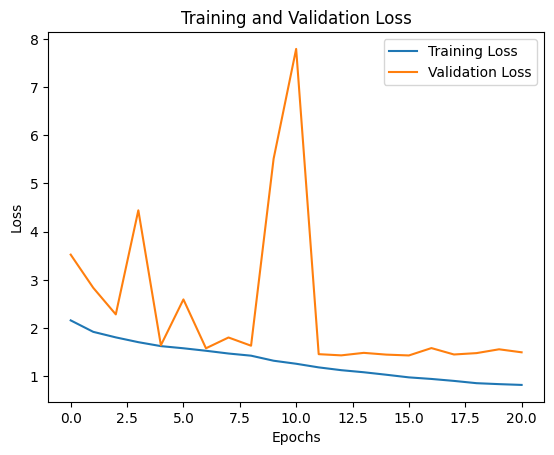

In [62]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Training the model with dropout regularization
cnn_model_v7_history = cnn_model_v7.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)

# Plot training and validation loss
plt.plot(cnn_model_v7_history.history['loss'], label='Training Loss')
plt.plot(cnn_model_v7_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
CNN Model V7 Classification Report:
               precision    recall  f1-score   support

       angry       0.37      0.41      0.38       958
     disgust       0.03      0.03      0.03       111
        fear       0.27      0.29      0.28      1024
       happy       0.82      0.67      0.73      1774
     neutral       0.48      0.51      0.50      1233
         sad       0.38      0.37      0.37      1247
    surprise       0.64      0.70      0.67       831

    accuracy                           0.49      7178
   macro avg       0.43      0.42      0.42      7178
weighted avg       0.51      0.49      0.50      7178

Accuracy: 0.49, Sensitivity: 0.03


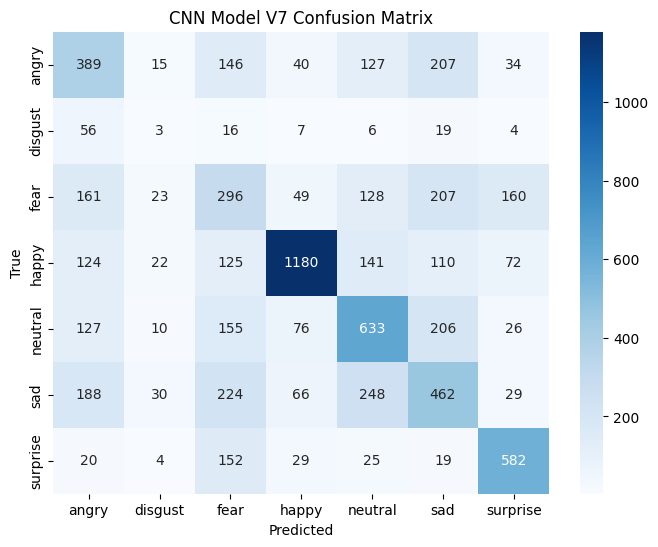

In [69]:
# Predict on the test data
cnn_v7_y_pred = cnn_model_v7.predict(test_data)
cnn_v7_y_pred_classes = np.argmax(cnn_v7_y_pred, axis=1)
cnn_v7_y_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cnn_v7_conf_matrix = confusion_matrix(cnn_v7_y_true, cnn_v7_y_pred_classes)

# Classification Report
print("CNN Model V7 Classification Report:\n", classification_report(cnn_v7_y_true, cnn_v7_y_pred_classes, target_names=categories))

# Accuracy and Sensitivity
cnn_v7_accuracy = np.trace(cnn_v7_conf_matrix) / np.sum(cnn_v7_conf_matrix)
cnn_v7_sensitivity = cnn_v7_conf_matrix[1, 1] / np.sum(cnn_v7_conf_matrix[1])
print(f"Accuracy: {cnn_v7_accuracy:.2f}, Sensitivity: {cnn_v7_sensitivity:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_v7_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("CNN Model V7 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [64]:
# Measure time per frame for real-time prediction
def measure_real_time_performance(sample_frame):
    start_time = time.time()
    processed_frame = cv2.resize(sample_frame, (IMG_SIZE, IMG_SIZE))
    processed_frame = processed_frame / 255.0
    processed_frame = np.expand_dims(processed_frame, axis=0)
    processed_frame = np.expand_dims(processed_frame, axis=-1)
    cnn_model_v7.predict(processed_frame)
    end_time = time.time()
    return end_time - start_time

# Example usage
sample_frame = test_data[0].reshape(IMG_SIZE, IMG_SIZE)  # Take any frame from test data
latency = measure_real_time_performance(sample_frame)
print(f"Average inference time per frame: {latency:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Average inference time per frame: 0.1071 seconds


This model have a slightly better accuracy of 1% as compared to model version 1 and version 3 but lower sensitivity as compared to them both, thus more adjustment is needed.

In [65]:
# Save the model for future use
cnn_model_v7.save("emotion_recognition_model_CNN_7.keras")

# 10. CNN Model Version 7 adjusted (Version 9)

Increasing the dropout slight more again and adding an extra layer

### Creating the Model

In [12]:
# Define the CNN model with regularization
cnn_model_v9 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.7),  
    Dense(len(categories), activation='softmax')  # Output layer
])

# Compile the model
cnn_model_v9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
cnn_model_v9.summary()

C:\Users\Chuang Ming Teo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 457,351 (1.74 MB)

 Trainable params: 456,391 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

### Training the Model

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.2265 - loss: 2.4924 - val_accuracy: 0.1589 - val_loss: 2.6007 - learning_rate: 0.0010
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.3564 - loss: 1.6966 - val_accuracy: 0.1987 - val_loss: 2.0253 - learning_rate: 0.0010
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.4248 - loss: 1.5564 - val_accuracy: 0.1987 - val_loss: 3.4841 - learning_rate: 0.0010
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.4722 - loss: 1.4313 - val_accuracy: 0.2044 - val_loss: 5.1747 - learning_rate: 0.0010
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5108 - loss: 1.3188 - val_accuracy: 0.4560 - val_loss: 1.5814 - learning_rate: 5.0000e-04
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.5651 - loss: 1.1879 - val_accuracy: 0.5109 - val_loss: 1.4255 - learning_rate: 5.0000e-04
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0

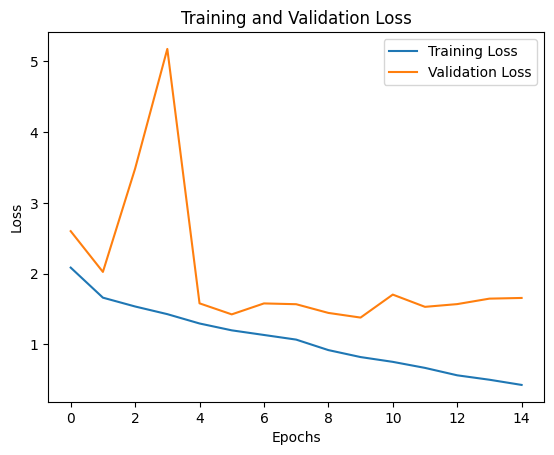

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Training the model with dropout regularization
cnn_model_v9_history = cnn_model_v9.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)

# Plot training and validation loss
plt.plot(cnn_model_v9_history.history['loss'], label='Training Loss')
plt.plot(cnn_model_v9_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
CNN Model V9 Classification Report:
               precision    recall  f1-score   support

       angry       0.38      0.44      0.41       958
     disgust       0.04      0.03      0.03       111
        fear       0.32      0.26      0.29      1024
       happy       0.77      0.67      0.72      1774
     neutral       0.46      0.52      0.49      1233
         sad       0.37      0.38      0.38      1247
    surprise       0.62      0.72      0.67       831

    accuracy                           0.50      7178
   macro avg       0.42      0.43      0.43      7178
weighted avg       0.50      0.50      0.50      7178

Accuracy: 0.50, Sensitivity: 0.03


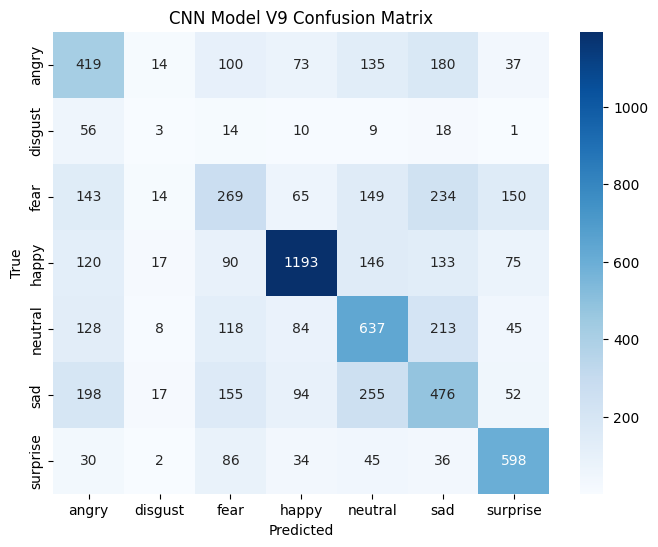

In [14]:
# Predict on the test data
cnn_v9_y_pred = cnn_model_v9.predict(test_data)
cnn_v9_y_pred_classes = np.argmax(cnn_v9_y_pred, axis=1)
cnn_v9_y_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cnn_v9_conf_matrix = confusion_matrix(cnn_v9_y_true, cnn_v9_y_pred_classes)

# Classification Report
print("CNN Model V9 Classification Report:\n", classification_report(cnn_v9_y_true, cnn_v9_y_pred_classes, target_names=categories))

# Accuracy and Sensitivity
cnn_v9_accuracy = np.trace(cnn_v9_conf_matrix) / np.sum(cnn_v9_conf_matrix)
cnn_v9_sensitivity = cnn_v9_conf_matrix[1, 1] / np.sum(cnn_v9_conf_matrix[1])
print(f"Accuracy: {cnn_v9_accuracy:.2f}, Sensitivity: {cnn_v9_sensitivity:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_v9_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("CNN Model V9 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Accuracy increases to 50%, but sensitivity remains at a low value. The overfitting issue seems to be continuing, with training loss continuing to decrease while validation loss does not.

In [15]:
# Measure time per frame for real-time prediction
def measure_real_time_performance(sample_frame):
    start_time = time.time()
    processed_frame = cv2.resize(sample_frame, (IMG_SIZE, IMG_SIZE))
    processed_frame = processed_frame / 255.0
    processed_frame = np.expand_dims(processed_frame, axis=0)
    processed_frame = np.expand_dims(processed_frame, axis=-1)
    cnn_model_v9.predict(processed_frame)
    end_time = time.time()
    return end_time - start_time

# Example usage
sample_frame = test_data[0].reshape(IMG_SIZE, IMG_SIZE)  # Take any frame from test data
latency = measure_real_time_performance(sample_frame)
print(f"Average inference time per frame: {latency:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Average inference time per frame: 0.3413 seconds


In [16]:
# Save the model for future use
cnn_model_v9.save("emotion_recognition_model_CNN_9.keras")

In [15]:
model = load_model("emotion_recognition_model_CNN_9.keras")

def measure_fps(model, test_data, num_frames=100, img_size=48):
    start_time = time.time()
    for i in range(num_frames):
        frame = test_data[i].reshape(img_size, img_size)
        processed_frame = cv2.resize(frame, (img_size, img_size))
        processed_frame = processed_frame / 255.0
        processed_frame = np.expand_dims(processed_frame, axis=0)
        processed_frame = np.expand_dims(processed_frame, axis=-1)
        model.predict(processed_frame, verbose=0)
    end_time = time.time()
    total_time = end_time - start_time
    fps = num_frames / total_time
    return fps

fps = measure_fps(model, test_data, num_frames=100)
print(f"Estimated frames processed per second: {fps:.2f}")

Estimated frames processed per second: 17.37


# 11. Real-time Integration Testing (WebCam)

In [4]:
# Constants
IMG_SIZE = 48
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
SMOOTHING_FRAMES = 10

# Load the model
model = load_model("emotion_recognition_model_CNN_9.keras")

def real_time_detection():
    cap = cv2.VideoCapture(0)  # Initialize webcam
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    predictions_queue = deque(maxlen=SMOOTHING_FRAMES)  # For smoothing predictions

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

            current_label = "No Face"
            for (x, y, w, h) in faces:
                roi = gray_frame[y:y+h, x:x+w]
                roi = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
                roi = roi / 255.0
                roi = np.expand_dims(roi, axis=0)
                roi = np.expand_dims(roi, axis=-1)
                
                prediction = model.predict(roi, verbose=0)
                label_index = np.argmax(prediction)
                predictions_queue.append(label_index)

                most_common_label = max(set(predictions_queue), key=predictions_queue.count)
                current_label = categories[most_common_label]
                confidence = np.max(prediction)

                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                cv2.putText(frame, f"{current_label} ({confidence:.2f})", 
                            (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

            cv2.imshow("Emotion Detection", frame)

            # Check for 'q' key or X button press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            if cv2.getWindowProperty("Emotion Detection", cv2.WND_PROP_VISIBLE) < 1:
                break

    except Exception as e:
        print(f"Error: {e}")
    
    finally:
        # Release resources in all cases
        cap.release()
        cv2.destroyAllWindows()
        print("Webcam released and all windows closed.")

# Run detection
real_time_detection()

Webcam released and all windows closed.
